In [54]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, calinski_harabasz_score, silhouette_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
# bayestian hyperparameter tunning
import optuna
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# models to try
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from myvars import input_features
from myfuncs import num_describe, generate_features
from myclasses import Windsorizer


pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Simulate future data

In [2]:
def separate_data():
    data = pd.read_csv('../data/processed/data.csv')
    data = data.dropna(subset=input_features)
    data = generate_features(data)
    data.query("calendarYear > 2018").to_csv('../data/processed/future.csv', index=False)
    data.query("calendarYear <= 2018").to_csv('../data/processed/present.csv', index=False)
    return None

In [3]:
separate_data()

c:\Users\fpala\2022\sp500\src\notebooks\myfuncs.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[feature_name] = data[col]/data.revenue
c:\Users\fpala\2022\sp500\src\notebooks\myfuncs.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[feature_name] = data[col]/data.revenue
c:\Users\fpala\2022\sp500\src\notebooks\myfuncs.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

# Train on different models

In [4]:
data = pd.read_csv('../data/processed/present.csv')
features = data.drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate'])
target = data.target

#### Train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    np.log(target), 
    test_size=0.25, 
    random_state = 46)
[x.shape for x in [X_train, X_test, y_train, y_test]]

[(5925, 76), (1975, 76), (5925,), (1975,)]

In [6]:
pd.concat([X_train,y_train], axis=1).to_csv('../data/processed/train.csv', index=False)
pd.concat([X_test,y_test], axis=1).to_csv('../data/processed/test.csv', index=False)

#### No model

In [7]:
n = len(y_test)
mean = y_train.mean()
worst_preds = np.tile(mean, n)
mean_squared_error(y_true=np.exp(y_test), y_pred = np.exp(worst_preds))

4624.240947756172

#### Linear Regression

In [8]:
def do_linear_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

In [9]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 725.4274788642791
mse test:  560.2357481576806
rmse test:  23.669299697238205


#### Polynomial Regression

In [11]:
def do_poly_regression(pipe, X_train, X_test, y_train, y_test=None, degree = 2):
    pipe.steps.append(('poly_transform', PolynomialFeatures(degree=degree)))
    pipe.steps.append(('regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_poly_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 290.9250096950543
mse test:  3.965944527788969e+120
rmse test:  1.991467932905014e+60


- **Insane Overfit**. 1e113 order of magnitude

#### Linear SVR

In [12]:
def do_linear_svm_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_svm', LinearSVR(C=0.02, max_iter=1000)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_svm_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 692.0856264052034
mse test:  566.0197971690108
rmse test:  23.791170571642976


- Check ill-conditioning. For C's larger than 0.02 it stops converging despite max_iter being 1000

#### SVM with radial basis functions

In [10]:
def do_svm_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rbf_svm', SVR(kernel = 'rbf', C=1.5, epsilon=0.1)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_svm_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 417.7711114964257
mse test:  567.7562519327167
rmse test:  23.827636306035828


Pipeline(steps=[('scaler', PowerTransformer()), ('rbf_svm', SVR(C=1.5))])

- Nice

#### KNN

In [20]:
def do_neighbors(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rfe', RFE(estimator = LinearRegression(), n_features_to_select = 5)))
    pipe.steps.append(('knn', KNeighborsRegressor(n_neighbors=5)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_neighbors(mypipe, X_train, X_test, y_train, y_test)

mse train: 602.5579938237018
mse test:  636.0603936293599
rmse test:  25.22023777900121


Pipeline(steps=[('scaler', PowerTransformer()),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=5)),
                ('knn', KNeighborsRegressor())])

- ok

#### Random Forest
- Including some basic hyperparameter tunning trying skopt interface for BayesSearch

In [14]:
def search_forest(pipe, X_train, X_test, y_train, y_test=None):
    model = RandomForestRegressor()
    param_grid={
        'max_depth':(3,10),
        'min_samples_leaf':(1e-3, 0.1, 'log-uniform'),
        'min_samples_split':(1e-3, 0.1, 'log-uniform'),
    }
    pipe.steps.append(('forest_optimizer', BayesSearchCV(model, search_spaces=param_grid, n_iter = 5, n_jobs=5,n_points = 5, verbose = 10, )))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
mypipe = search_forest(mypipe, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
mse train: 292.47084581120157
mse test:  428.3632211142772
rmse test:  20.696937481527968


In [15]:
a = mypipe['forest_optimizer']
a.best_params_, a.best_score_

(OrderedDict([('max_depth', 9),
              ('min_samples_leaf', 0.0010256600861588028),
              ('min_samples_split', 0.0023241843515524204)]),
 0.912892830173391)

- High overfitting because RF has no regularization process

#### Gradient Boosting
- Change scorer to a better suited one. Abandoned, takes ages, skopt wasn't working out, back to optuna

In [16]:
def custom_score(y, y_pred, **kwargs):
    return mean_squared_error(y_true=np.exp(y), y_pred=np.exp(y_pred))

In [13]:
def search_boosting(pipe, X_train, X_test, y_train, y_test=None):
    def objective(trial):
        params={
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": "gbtree",
            "min_child_weight": trial.suggest_int("min_child_weight", 20, 500),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_depth" : trial.suggest_int("max_depth", 5, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
            "subsample" : trial.suggest_float("subsample", 0.5, 1),
            "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
            }
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
            ])
        pipe.fit(X_train,y_train)
        preds = pipe.predict(X_test)
        mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
        return mse

    minutes = 20
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

In [32]:
results, study = search_boosting(mypipe, X_train, X_test, y_train, y_test)
study.best_trial.value, study.best_trial.params

(286.40738209295756,
 {'min_child_weight': 58,
  'alpha': 0.027230585245890622,
  'max_depth': 10,
  'colsample_bytree': 0.505661088108428,
  'subsample': 0.6226860565996696,
  'eta': 0.1485581680577813})

Assess results

In [21]:
params =  {
    'min_child_weight': 58,
    'alpha': 0.027230585245890622,
    'max_depth': 10,
    'colsample_bytree': 0.505661088108428,
    'subsample': 0.6226860565996696,
    'eta': 0.1485581680577813
  }
pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
])
pipe.fit(X_train,y_train)
preds_test = pipe.predict(X_test)
preds_train = pipe.predict(X_train)
mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
print('mse train:', mse_train)
print('mse test: ', mse_test)
print('rmse test: ', np.sqrt(mse_test))
preds = pipe.predict(X_test)
predictions = pd.DataFrame(zip(np.exp(preds), np.exp(y_test)), columns=['predicted', 'real'], index=X_test.index)
df_predictions = pd.concat([data.loc[X_test.index,:], predictions], axis=1)
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear'])[['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap']]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

mse train: 320.85753017665377
mse test:  434.98806883468836
rmse test:  20.85636758485735


,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,error
1826,CSCO,2000,2000-09-29,640.96695,317.57532,326.03867,-323.39164
3194,GOOGL,2017,2018-02-06,823.17064,534.44330,644.27240,-288.72734
3181,GOOG,2017,2018-02-06,756.45198,528.85345,578.54152,-227.59853
3066,GE,1997,1997-12-31,389.20414,230.90846,250.48968,-158.29567
2003,CVX,2016,2017-02-23,238.62691,83.62045,184.75681,-155.00646
...,...,...,...,...,...,...,...
3998,JPM,1999,1999-12-31,94.59199,205.23396,148.31221,110.64198
5717,PFE,2004,2005-02-28,276.16944,389.14148,391.07994,112.97204
3732,INTC,2002,2003-03-11,164.89576,285.91403,321.78971,121.01828
6730,T,1999,1999-12-31,241.21551,419.39914,642.79239,178.18363


Try on future data

In [22]:
future_data = pd.read_csv('../data/processed/future.csv')
future_features = future_data.drop(columns=['symbol', 'calendarYear', 'fillingDate', 'target'])
future_target = future_data.target
preds = pipe.predict(future_features)
mse = mean_squared_error(y_true=future_target, y_pred=np.exp(preds))

In [29]:
mse

16340.097082075887

In [28]:
predictions = pd.DataFrame(zip(np.exp(preds), future_target), columns=['predicted', 'real'], index=future_features.index)
df_predictions = pd.concat([future_data.loc[future_features.index,:], predictions], axis=1)
context = ['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap', 'totalAssets', 'retainedEarningsToAssets', 'ebitda', 'netDebt']
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear']).loc[:,context]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,ebitda,netDebt,error
11,AAPL,2021,2021-10-28,2522.28195,519.40314,2104.10094,358.01966,0.01585,125.59853,-67.11231,-2002.87881
945,MSFT,2021,2021-07-29,2232.30744,546.01093,1689.97110,343.44115,0.17094,87.59918,-70.52696,-1686.29652
10,AAPL,2020,2020-10-30,2104.10094,530.19476,1215.20182,342.59619,0.04621,85.70057,-83.97965,-1573.90618
606,GOOGL,2021,2022-02-02,1862.05763,422.60349,1429.52317,361.12663,0.53298,104.05727,-141.53104,-1439.45414
603,GOOG,2021,2022-02-02,1860.82749,422.60349,1459.94199,361.12663,0.53298,104.05727,-141.53104,-1438.22400
...,...,...,...,...,...,...,...,...,...,...,...
1142,PYPL,2021,2022-02-03,162.02229,216.51086,353.19692,76.19595,0.21813,5.62594,-7.28648,54.48858
170,BAC,2021,2022-02-22,349.42675,406.86017,328.04066,3185.88421,0.05934,40.82299,-1484.58270,57.43342
713,INTC,2020,2021-01-22,255.79947,325.58777,303.64157,161.42086,0.36732,40.01144,5.44284,69.78830
293,CMCSA,2021,2022-02-02,226.04132,299.44333,249.04645,277.33260,0.22436,37.69791,77.85247,73.40201


In [25]:
df_predictions.predicted.idxmax()

945

In [26]:
pd.DataFrame(zip(future_features.columns, pipe['xgb'].feature_importances_)).sort_values(by=1, ascending=False)

,0,1
6,previousMarketCap,0.38263
3,ebitda,0.12965
1,revenue,0.07116
0,totalAssets,0.03164
26,researchAndDevelopmentExpensesToRevenue,0.02967
29,operatingIncomeToRevenue,0.02200
43,stockBasedCompensationToRevenue,0.01793
8,shortTermInvestmentsToAssets,0.01544
30,netIncomeToRevenue,0.01173
46,freeCashFlowToRevenue,0.01134


WTF... Inspect these values
- Awful at predicting tech which is causing the huge mae
- Maybe it has to do with the fact the its capturing the trends of the times

#### KMeans
- Inconclusive Results

In [86]:
clusters = []
inertias = []
ch_scores = []
sil_scores = []

pipe = Pipeline(
    steps = [
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer())
    ]
)
data = pipe.fit_transform(X_train)
for a in range(2,20):
    print(a)
    kmeans = KMeans(n_clusters=a)
    kmeans.fit(data)
    clusters.append(a)
    inertias.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(data, kmeans.labels_))
    sil_scores.append(silhouette_score(data, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


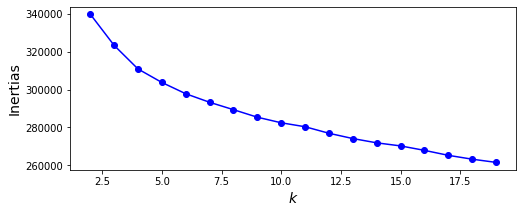

In [90]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertias", fontsize=14)
plt.show()

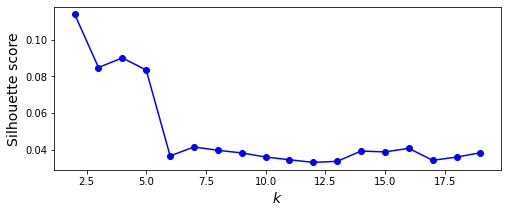

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

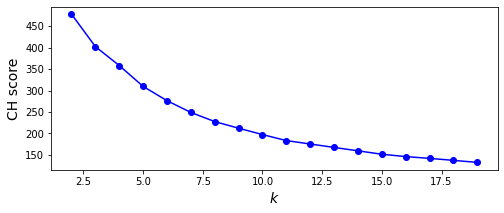

In [92]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, ch_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("CH score", fontsize=14)
plt.show()

-> This does not do what I want, I want to transform each observation to de distance to its centroid.

# v2
- clipping the the previousMarketCap feature destroys outliers. 
  - Filter clipping by kurtosis
  - Predict Increases
- Try to simulate a neural network with different algorithms

### Try to predict separating train on test based on time

In [38]:
data = pd.read_csv('../data/processed/present.csv')
data.query("calendarYear >= 2016").shape, data.query("calendarYear < 2016").shape

((1435, 146), (4883, 146))

In [39]:
features_test = data.query("calendarYear > 2016").drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate'])
target_test = np.log(data.query("calendarYear > 2016").target)
features_train = data.query("calendarYear <= 2016").drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate'])
target_train = np.log(data.query("calendarYear <= 2016").target)

In [40]:
[a.shape for a in [features_train, features_test, target_train, target_test]]

[(5351, 141), (967, 141), (5351,), (967,)]

In [41]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, features_train, features_test, target_train, target_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


mse train: 1190.047664523396
mse test:  3253.006347114777
rmse test:  57.0351325685737


- At least we've managed to replicate the problem, now we have something we can work with

In [14]:
results, study = search_boosting(mypipe, features_train, features_test, target_train, target_test)

[I 2022-04-20 00:48:09,179] A new study created in memory with name: no-name-724ff54e-b55f-4984-9d5b-329e0394da76
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-20 00:48:13,083] Trial 0 finished with value: 6827.503915112516 and parameters: {'min_child_weight': 354, 'alpha': 4.453202509992071e-05, 'max_depth': 8, 'colsample_bytree': 0.9664625408466313, 'subsample': 0.5397659499403213, 'eta': 0.036738173411862765}. Best is trial 0 with value: 6827.503915112516.
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-20 00:48:16,695] Trial 1 finished with value: 8244.479708284107 and parameters: {'min_child_weight': 454, 'alpha': 0.05020610339937164, 'max

In [20]:
study.best_trial.value, study.best_trial.params

(1229.970786942123,
 {'min_child_weight': 21,
  'alpha': 4.942615434527387e-06,
  'max_depth': 13,
  'colsample_bytree': 0.9188509285361383,
  'subsample': 0.8928671489358959,
  'eta': 0.16142476850744988})

In [21]:
params =  {
    'min_child_weight': 21,
    'alpha': 4.942615434527387e-06,
    'max_depth': 13,
    'colsample_bytree': 0.9188509285361383,
    'subsample': 0.8928671489358959,
    'eta': 0.16142476850744988
  }
pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
])
pipe.fit(features_train,target_train)
preds_test = pipe.predict(features_test)
preds_train = pipe.predict(features_train)
mse_test = mean_squared_error(y_true=np.exp(target_test), y_pred=np.exp(preds_test))
mse_train = mean_squared_error(y_true=np.exp(target_train), y_pred=np.exp(preds_train))

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [22]:
print('mse train:', mse_train)
print('mse test: ', mse_test)
print('rmse test: ', np.sqrt(mse_test))

mse train: 14.273936728016926
mse test:  1229.970786942123
rmse test:  35.07093935072346


Brutal overfit? let's check

In [28]:
future_data = pd.read_csv('../data/processed/future.csv')
future_features = future_data.drop(columns=['symbol', 'calendarYear', 'fillingDate', 'target'])
future_target = future_data.target
preds = pipe.predict(future_features)
mse = mean_squared_error(y_true=future_target, y_pred=np.exp(preds))

In [30]:
r2_score(y_true=future_target, y_pred=np.exp(preds))

0.5459493656515411

In [35]:
predictions = pd.DataFrame(zip(np.exp(preds), future_target), columns=['predicted', 'real'], index=future_features.index)
df_predictions = pd.concat([future_data.loc[future_features.index,:], predictions], axis=1)
context = ['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap', 'totalAssets', 'retainedEarningsToAssets', 'netDebt']
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear']).loc[:,context]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,error
11,AAPL,2021,2021-10-28,2522.28195,580.82471,2104.10094,358.01966,0.01585,-67.11231,-1941.45724
945,MSFT,2021,2021-07-29,2232.30744,586.79883,1689.97110,343.44115,0.17094,-70.52696,-1645.50861
10,AAPL,2020,2020-10-30,2104.10094,508.75714,1215.20182,342.59619,0.04621,-83.97965,-1595.34380
108,AMZN,2020,2021-02-03,1775.95251,438.52985,1077.89170,338.67049,0.16361,-0.00738,-1337.42267
606,GOOGL,2021,2022-02-02,1862.05763,535.41132,1429.52317,361.12663,0.53298,-141.53104,-1326.64631
...,...,...,...,...,...,...,...,...,...,...
1267,T,2021,2022-02-16,171.42955,232.91690,217.93919,554.47522,0.07677,172.39983,61.48735
1012,NVDA,2019,2019-02-21,105.69150,180.86304,167.92988,14.44950,0.94524,-5.90680,75.17154
1068,PENN,2021,2022-02-28,7.90313,92.74256,114.87510,16.96024,-0.00510,5.81491,84.83943
929,MPWR,2021,2022-02-25,20.16374,127.15799,169.41610,1.59503,0.26775,-0.72883,106.99425


<AxesSubplot:xlabel='predicted', ylabel='real'>

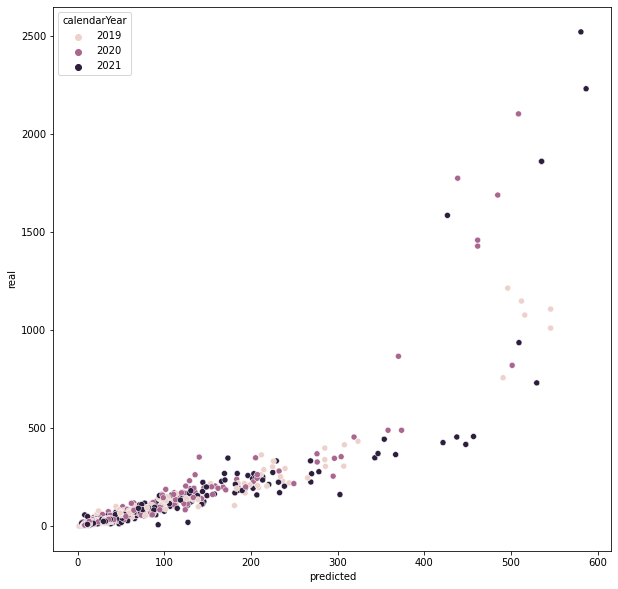

In [36]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = df_predictions, x= 'predicted', y='real', hue='calendarYear')

In [37]:
pd.DataFrame(zip(future_features.columns, pipe['xgb'].feature_importances_)).sort_values(by=1, ascending=False)

,0,1
66,previousMarketCap,0.52610
70,freeCashFlow,0.08101
1,chicagoFedFinancialConditions,0.02705
42,wilshire5000YearOverYear,0.02586
16,nasdaq,0.02312
38,nasdaqYearOverYear,0.01811
32,inventorySalesRatioYearOverYear,0.01732
67,totalAssets,0.01175
17,stlouisFredFinancialStress,0.01060
26,GDPYearOverYear,0.00901


### Attempt to predict increases instead of absolute values

In [61]:
def do_linear_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_absolute_error(y_true=y_test, y_pred=preds_test)
    mse_train = mean_absolute_error(y_true=y_train, y_pred=preds_train)
    print('mse train:', mse_train)
    print('mse test: ', mse_test)

In [67]:
def search_boosting(pipe, X_train, X_test, y_train, y_test=None):
    def objective(trial):
        params={
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "min_child_weight": trial.suggest_int("min_child_weight", 20, 500),
            "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            "max_depth" : trial.suggest_int("max_depth", 5, 10),
            "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
            "subsample" : trial.suggest_float("subsample", 0.5, 1),
            "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
            }
        pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
            ])
        pipe.fit(X_train,y_train)
        preds = pipe.predict(X_test)
        mse = mean_absolute_error(y_true=y_test, y_pred=preds)
        return mse

    minutes = 10
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=(60*minutes))
    results = study.trials_dataframe()
    return results, study

In [63]:
data = pd.read_csv('../data/processed/present.csv')
data.query("calendarYear >= 2016").shape, data.query("calendarYear < 2016").shape

((1435, 147), (4883, 147))

In [64]:
features_test = data.query("calendarYear > 2016").drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate', 'targetYoY'])
target_test = data.query("calendarYear > 2016").targetYoY
features_train = data.query("calendarYear <= 2016").drop(columns=['target', 'symbol', 'calendarYear', 'fillingDate', 'targetYoY'])
target_train = data.query("calendarYear <= 2016").targetYoY

In [65]:
[a.shape for a in [features_train, features_test, target_train, target_test]]

[(5351, 142), (967, 142), (5351,), (967,)]

In [66]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, features_train, features_test, target_train, target_test)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


mse train: 0.22286622398624073
mse test:  0.22684901734416765


In [68]:
results, study = search_boosting(mypipe, features_train, features_test, target_train, target_test)

[I 2022-04-20 02:15:57,144] A new study created in memory with name: no-name-79e5ee6d-c68b-47df-bee6-5538aeafd15b
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-20 02:16:01,329] Trial 0 finished with value: 0.2041646297927524 and parameters: {'min_child_weight': 285, 'alpha': 3.1450381164535973e-06, 'max_depth': 5, 'colsample_bytree': 0.9265000936173176, 'subsample': 0.8498257214705593, 'eta': 0.10857295304586415}. Best is trial 0 with value: 0.2041646297927524.
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
[I 2022-04-20 02:16:05,773] Trial 1 finished with value: 0.20592682351623676 and parameters: {'min_child_weight': 202, 'alpha': 0.4493203943733698, '

In [69]:
study.best_trial.value, study.best_trial.params

(0.1976961636954313,
 {'min_child_weight': 97,
  'alpha': 1.0797968706087468e-05,
  'max_depth': 10,
  'colsample_bytree': 0.9543659397032849,
  'subsample': 0.753398775048909,
  'eta': 0.0719481709483498})

In [79]:
params =  {'min_child_weight': 97,
  'alpha': 1.0797968706087468e-05,
  'max_depth': 10,
  'colsample_bytree': 0.9543659397032849,
  'subsample': 0.753398775048909,
  'eta': 0.0719481709483498}
pipe = Pipeline(steps=[
            ('scaler', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
])
pipe.fit(features_train,target_train)
preds_test = pipe.predict(features_test)
preds_train = pipe.predict(features_train)
mse_test = mean_squared_error(y_true=target_test, y_pred=preds_test)
mse_train = mean_squared_error(y_true=target_train, y_pred=preds_train)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [80]:
print('mse train:', mse_train)
print('mse test: ', mse_test)
print('rmse test: ', np.sqrt(mse_test))

mse train: 0.13625708537923498
mse test:  0.10779080531802686
rmse test:  0.3283151006548844


In [81]:
r2_score(y_true=target_train, y_pred=preds_train)

0.5439956778950903

mejor!

In [82]:
future_data = pd.read_csv('../data/processed/future.csv')
future_features = future_data.drop(columns=['symbol', 'calendarYear', 'fillingDate', 'target', 'targetYoY'])
future_target = future_data.targetYoY
preds = pipe.predict(future_features)
mean_absolute_error(y_true=future_target, y_pred=preds)

0.22826146667541938

In [83]:
r2_score(y_true=future_target, y_pred=preds)

0.1770036983293396

In [84]:
predictions = pd.DataFrame(zip(np.exp(preds), future_target), columns=['predicted', 'real'], index=future_features.index)
df_predictions = pd.concat([future_data.loc[future_features.index,:], predictions], axis=1)
context = ['symbol','calendarYear','fillingDate','real', 'predicted','previousMarketCap', 'totalAssets', 'retainedEarningsToAssets', 'netDebt', 'target']
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear']).loc[:,context]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,target,error
1298,TMUS,2019,2020-02-06,4.99261,2.42773,13.07212,93.00749,-0.10162,13.58808,78.33611,-2.56488
1279,TER,2020,2021-02-22,5.02846,2.48794,3.74679,3.85205,0.10605,-1.58210,22.58738,-2.54053
807,LDOS,2019,2020-02-18,4.36652,2.07497,3.30424,10.18300,0.09565,2.49903,17.73228,-2.29155
1130,PTC,2021,2021-11-22,3.56784,3.06752,2.93239,4.59867,0.09197,1.34816,13.39471,-0.50032
701,IFF,2020,2021-02-22,1.51948,1.14738,14.24177,13.53788,0.32371,0.69844,35.88190,-0.37210
...,...,...,...,...,...,...,...,...,...,...,...
964,NCLH,2020,2021-02-26,-0.01850,2.17428,8.84793,19.40133,-0.01606,8.96838,8.68425,2.19278
1460,WYNN,2021,2022-02-28,-0.37359,1.82048,14.99101,12.59662,-0.18258,9.64199,9.39054,2.19407
979,NI,2020,2021-02-17,-0.22041,2.07406,11.67339,23.24061,-0.08009,9.88778,9.10042,2.29448
1133,PVH,2021,2021-03-31,1.64510,4.25750,2.87267,13.98695,0.27178,3.95112,7.59850,2.61240


In [88]:
df_predictions['predictedMarketCap'] = df_predictions.previousMarketCap * df_predictions.predicted

In [96]:
df_predictions

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,target,error,predictedMarketCap
0,A,2019,2019-12-19,0.20543,1.22422,23.50679,10.14027,-0.00190,0.99011,28.33586,1.01879,28.77753
1,A,2020,2020-12-18,0.37102,1.26708,28.33586,10.18350,0.00841,0.63674,38.84897,0.89606,35.90381
2,A,2021,2021-11-22,0.22534,1.28936,38.84897,10.86931,0.03251,0.98378,47.60321,1.06402,50.09013
3,AAL,2019,2020-02-19,-0.26895,1.15752,16.97603,64.19635,0.03774,31.69161,12.41028,1.42648,19.65017
4,AAL,2020,2021-02-17,-0.04930,1.62125,12.41028,65.38252,-0.10747,36.01530,11.79842,1.67055,20.12010
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,ZION,2020,2021-02-25,0.22668,1.48187,7.71797,85.91283,0.05288,-34.86389,9.46747,1.25519,11.43699
1490,ZION,2021,2022-02-25,0.07593,1.01630,9.46747,93.68290,0.05553,-59.38347,10.18633,0.94038,9.62183
1491,ZTS,2019,2019-12-31,0.42571,1.06045,47.56083,12.35429,0.38342,5.00658,67.80811,0.63474,50.43593
1492,ZTS,2020,2021-02-16,0.20407,1.28679,67.80811,14.35039,0.41580,3.96456,81.64559,1.08272,87.25463


In [101]:
df_predictions.sort_values(by='error').head(100)

,symbol,calendarYear,fillingDate,real,predicted,previousMarketCap,totalAssets,retainedEarningsToAssets,netDebt,target,error,predictedMarketCap
1298,TMUS,2019,2020-02-06,4.99261,2.42773,13.07212,93.00749,-0.10162,13.58808,78.33611,-2.56488,31.73554
1279,TER,2020,2021-02-22,5.02846,2.48794,3.74679,3.85205,0.10605,-1.58210,22.58738,-2.54053,9.32178
807,LDOS,2019,2020-02-18,4.36652,2.07497,3.30424,10.18300,0.09565,2.49903,17.73228,-2.29155,6.85620
1130,PTC,2021,2021-11-22,3.56784,3.06752,2.93239,4.59867,0.09197,1.34816,13.39471,-0.50032,8.99517
701,IFF,2020,2021-02-22,1.51948,1.14738,14.24177,13.53788,0.32371,0.69844,35.88190,-0.37210,16.34079
610,GPN,2019,2020-02-21,1.93400,1.60044,21.59482,47.59529,0.05245,8.55932,63.35929,-0.33356,34.56122
401,DISCK,2020,2021-02-22,1.27576,1.07829,14.45164,35.94249,0.25062,13.50271,32.88852,-0.19748,15.58301
541,FIS,2019,2020-02-20,1.65585,1.49509,38.11796,89.67440,0.04965,20.51105,101.23552,-0.16076,56.98990
73,ALGN,2020,2021-02-26,1.39065,1.26045,19.12471,5.09344,0.45870,-0.92225,45.72044,-0.13019,24.10582
92,AMD,2019,2020-02-04,1.36249,1.37927,27.57630,6.45103,-1.17682,-1.10425,65.14876,0.01677,38.03504


<AxesSubplot:xlabel='predicted', ylabel='real'>

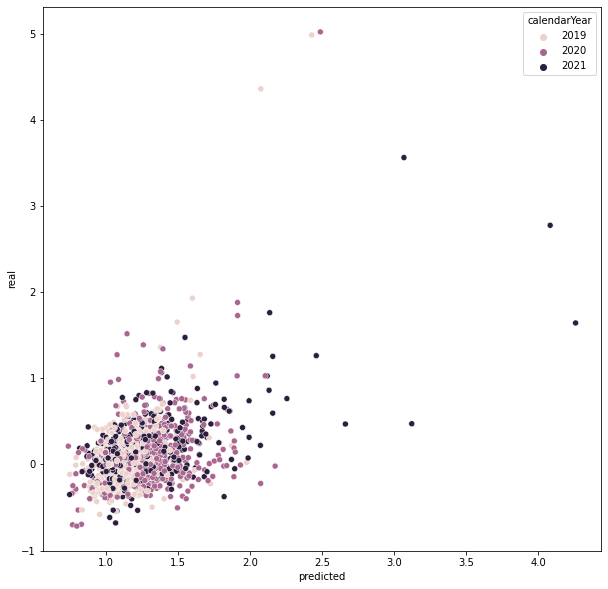

In [86]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = df_predictions, x= 'predicted', y='real', hue='calendarYear')

In [102]:
pd.DataFrame(zip(future_features.columns, pipe['xgb'].feature_importances_)).sort_values(by=1, ascending=False)

,0,1
32,inventorySalesRatioYearOverYear,0.11715
42,wilshire5000YearOverYear,0.08198
38,nasdaqYearOverYear,0.05003
99,operatingIncomeToRevenue,0.03095
129,dividendsPaidToRevenueYearOverYear,0.02966
55,leadingIndexSMA3,0.02845
10,inventorySalesRatio,0.02771
24,consumerSentimentYearOverYear,0.02658
66,previousMarketCap,0.02518
92,retainedEarningsToAssets,0.02337
